# Melanoma Detection Assignment
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment is split into:
1. Data Reading/Data Understanding, Dataset Creation
2. Dataset visualisation
3. Model Building

  - 3.1 Initial Model Building
  - 3.2 Model Building with Augmented Data
  - 3.3 Handling class imbalances
  - 3.4 Model Building & training on the rectified class imbalance dataset
4. Model Prediction

In [2]:
#Import necessary libraries
import pathlib
import os
import glob
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Dropout, Dense, Flatten

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import load_img

### Utility API's

In [3]:
#API to return Model
#It takes drop_out, bath_norm as inputs
# to check, if dropouts, and batch normalization to be added in model
def get_model(drop_out,batch_norm):
  #In this case  we are using 3 Convollution layers (Conv2D+Maxpool2D), followed by Flatten (to convert to 1D), and Dense Layer
  model = Sequential()
  #Sequential allows you to create models layer-by-layer
  # Rescaling Images to Normal Pixel Value
  model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

  #First Convulation layer
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))

  #Second Convulation Layer
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))


  #Third Convulation Layer
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
  #Batch Normalization
  if batch_norm == True:
    model.add(BatchNormalization())

  model.add(MaxPool2D(pool_size=(2,2)))

  #DropOut
  if drop_out == True:
    # Dropout at hidder layer with 40% Fraction of the input units to drop.
    model.add(Dropout(0.4))

  #Flatten Layer
  ##To flatten the multi-dimensional input tensors into a single dimension.
  model.add(Flatten())

  #Dense Layer
  model.add(Dense(128,activation='relu'))

  #DropOut
  if drop_out == True:
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(0.25))

  if batch_norm == True:
    model.add(BatchNormalization())

  #Dense Layer with softmax activation function.
  model.add(Dense(len(class_names),activation='softmax'))
  return model

In [4]:
#Define data_augmentation
data_augmentation = keras.Sequential([
      layers.experimental.preprocessing.RandomFlip(mode="horizontal",input_shape=(180,180,3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
])

In [24]:
#Augmented Model, with dropouts
def get_augmented_model():
  model = Sequential(
      [
          data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3))
      ]
  )
  #First Convolution layer
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  #Second Convolution Layer
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  #Third Convolution Layer
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  #DropOut  layer with 40% Fraction of the input units to drop.
  model.add(Dropout(0.4))

  #Flatten Layer
  ##To flatten the multi-dimensional input tensors into a single dimension.
  model.add(Flatten())

  #Dense Layer
  model.add(Dense(128,activation='relu'))

  #DropOut
  #Dropout layer with 25% Fraction of the input units to drop.
  model.add(Dropout(0.25))

  #Dense Layer with softmax activation function.
  model.add(Dense(len(class_names),activation='softmax'))
  return model

In [6]:
#Utility API to plot the model
def plot_model(history,epochs):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [7]:
#Utility API for getting class distribution count
def get_class_distribution_count(dir_path):

    #count number of image in each classes
    sub_dir_file_count= []
    sub_dir_name = []
    for path in pathlib.Path(dir_path).iterdir():
        if path.is_dir():
            sub_dir_file_count.append(len([dir_name for dir_name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, dir_name))]))
    #Sub Directory Names
    sub_dir_name = [dir_name for dir_name in os.listdir(dir_path)
                    if os.path.isdir(os.path.join(dir_path, dir_name))]
    return sub_dir_name,sub_dir_file_count

### 1. Data Reading/Data Understanding, Dataset Creation

In [8]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!unzip "/content/gdrive/MyDrive/MelanomaCancerDetectionDataSet.zip" > /dev/null

In [10]:
# Defining the path for train and test images
train_data_dir = pathlib.Path("/content/Train/")
test_data_dir = pathlib.Path("/content/Test/")

In [11]:
# Counting the number of image in train and test

#Train Data  count
train_img_count = len(list(train_data_dir.glob('*/*.jpg')))
print("Train Data Image Count:",train_img_count)

#Test Data count
test_img_count = len(list(test_data_dir.glob('*/*.jpg')))
print("Test Data Image Count:",test_img_count)

Train Data Image Count: 2239
Test Data Image Count: 118


#### Dataset Creation:

- Create train & validation dataset from the train directory with a batch size of 32.
- Resize images to 180*180

In [59]:
BATCH_SIZE = 32

In [62]:
#Splitting Train DataSet
#Loading images off Disk
#subset is  set as "training" to get only train data set
#"seed" is used as 123 as recommended
train_ds = preprocessing.image_dataset_from_directory(train_data_dir,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=(180,180),
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
#Splitting Validation DataSet
#subset is  set as "validation" to get only train data set
#Loading images off Disk
#"seed" is used as 123 as recommended
val_ds = preprocessing.image_dataset_from_directory(train_data_dir,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=(180,180),
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### 2. Visualize the data:

- Create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
/content/Train/actinic keratosis/ISIC_0031040.jpg
/content/Train/basal cell carcinoma/ISIC_0028059.jpg
/content/Train/dermatofibroma/ISIC_0026313.jpg
/content/Train/melanoma/ISIC_0000549.jpg
/content/Train/nevus/ISIC_0000047.jpg
/content/Train/pigmented benign keratosis/ISIC_0028080.jpg
/content/Train/seborrheic keratosis/ISIC_0010878.jpg
/content/Train/squamous cell carcinoma/ISIC_0030175.jpg
/content/Train/vascular lesion/ISIC_0025244.jpg


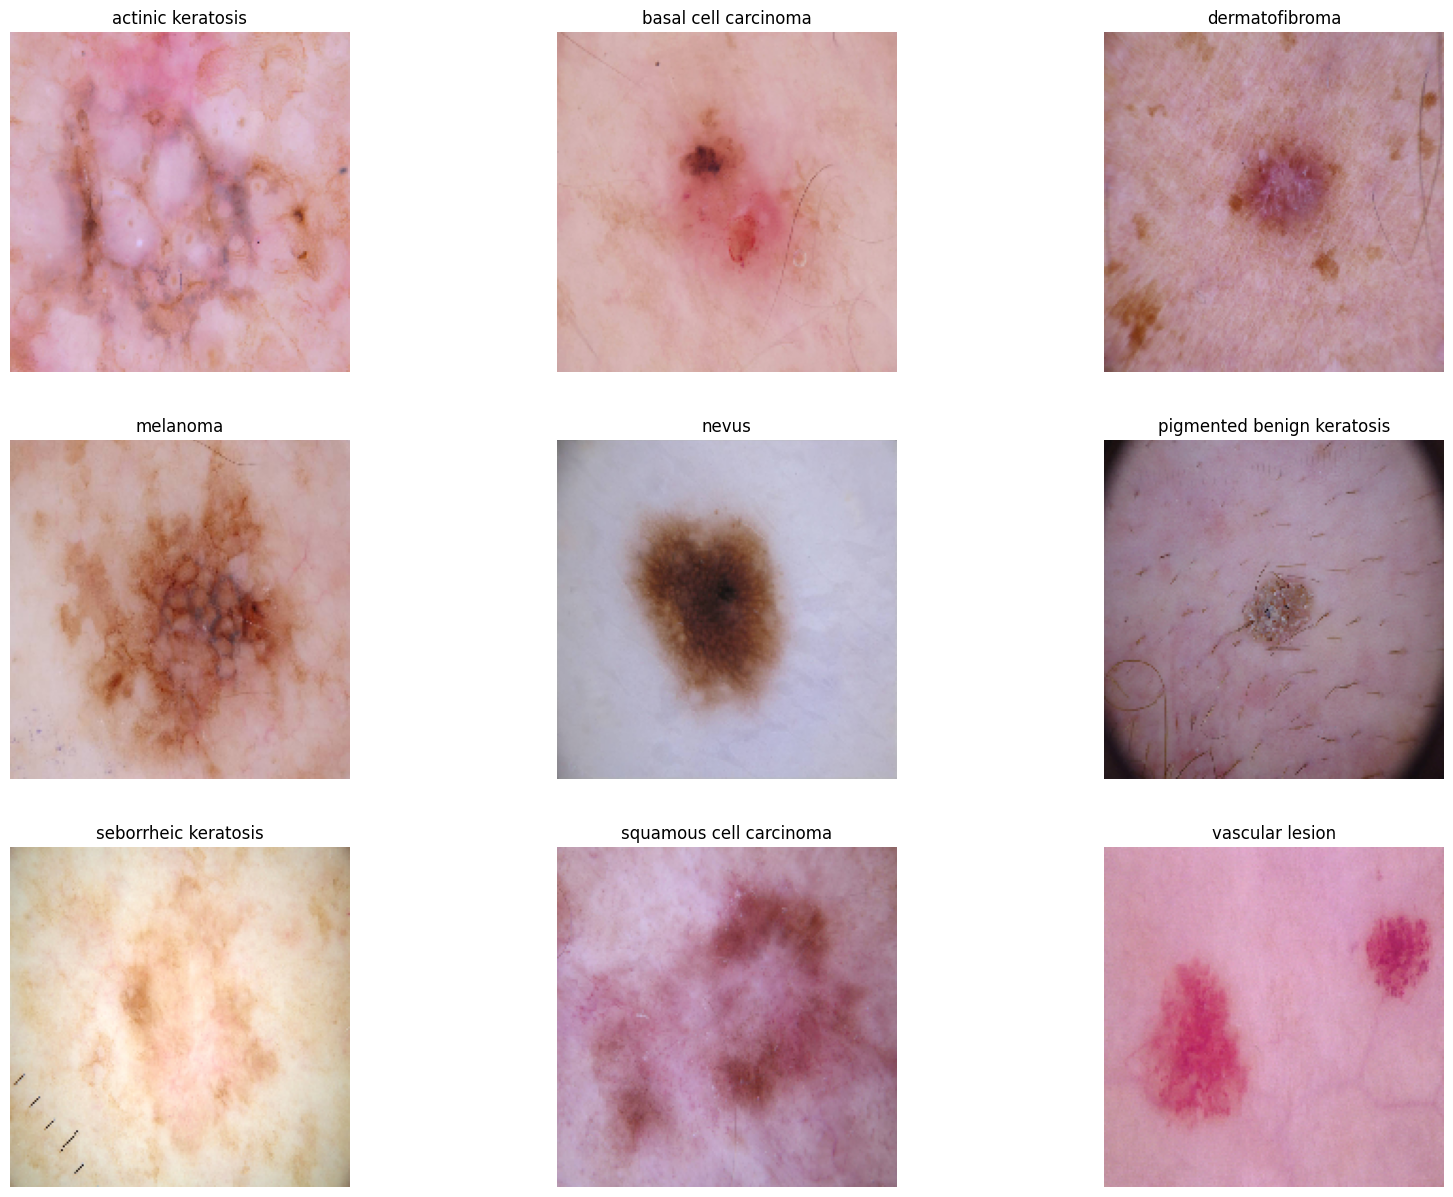

In [14]:
#Visualize one instance of all the class present in the dataset.
image_batch = preprocessing.image_dataset_from_directory(train_data_dir,batch_size=BATCH_SIZE,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#All the classes of  Melanoma Skin Cancer
class_names = image_batch.class_names
print(class_names)

#Dictionary to store the path of image as per the class
class_file_path = {}

#Data Visualization
index = 0
#Extracting 1st file of the path
#So total 9 images will be printed
plt.figure(figsize=(20,15))
for each_class in class_names:
  curr_path = str(train_data_dir)+'/'+each_class+'/'
  class_file_path[each_class] = curr_path + os.listdir(curr_path)[0]
  print(class_file_path[each_class])
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(load_img(class_file_path[each_class],target_size=(180,180)))
  plt.title(each_class)
  plt.axis("off") # Dont show X, Y axis


### 3. Model Building

In [15]:
#Get the class names
train_ds_cls_names = train_ds.class_names
train_ds_cls_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [16]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
#Model Parameters
#Below model optimizer, loss function is deinfed to be used across all models
#Adam Optimizer: "Adam" is based on adaptive estimation of first-order and second-order moments,a dn it helps to converge faster
#categorical_crossentropy Loss function: for multi-class classification model as there are 9 classes of cancer defined
MODEL_OPTIMIZER = "adam"
MODEL_LOSS = "categorical_crossentropy"
MODEL_METRICS = "accuracy"

#Number of Epochs
INITIAL_NUMBER_OF_EPOCHS = 20 #For initail Models
FINAL_NUMBER_OF_EPOCHS = 30 #For final model with Augmentor Library

#### 3.1 Initial Model Building

##### **Model1**: No DropOuts and No BN (Batch Normalization)

In [83]:
#Model without any dropout and batch normalization
model1 = get_model(False,False)

In [84]:
#Summary
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [85]:
#Model Compilation
model1.compile(optimizer=MODEL_OPTIMIZER,loss=MODEL_LOSS,metrics=[MODEL_METRICS])

In [86]:
# Train the model
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=INITIAL_NUMBER_OF_EPOCHS)

Epoch 1/20
56/56 [==============================] - 211s 3s/step - loss: 1.9636 - accuracy: 0.2812 - val_loss: 1.7833 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 194s 3s/step - loss: 1.6438 - accuracy: 0.4068 - val_loss: 1.4934 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 168s 3s/step - loss: 1.4259 - accuracy: 0.4972 - val_loss: 1.4661 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 177s 3s/step - loss: 1.3389 - accuracy: 0.5084 - val_loss: 1.4220 - val_accuracy: 0.5570
Epoch 5/20
56/56 [==============================] - 176s 3s/step - loss: 1.2622 - accuracy: 0.5413 - val_loss: 1.3608 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 165s 3s/step - loss: 1.1910 - accuracy: 0.5686 - val_loss: 1.3571 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 175s 3s/step - loss: 1.1601 - accuracy: 0.5792 - val_loss: 1.4849 - val_accuracy: 0.5414
Epoch 8/20
56

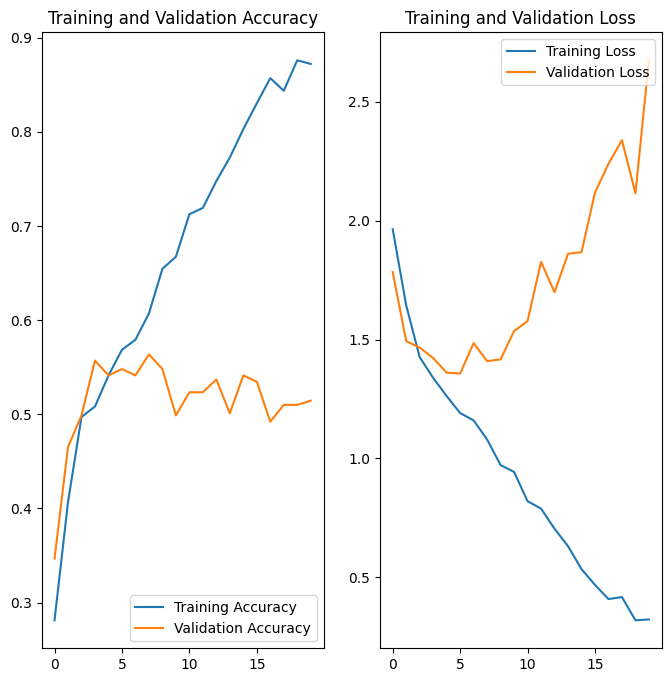

In [87]:
#Plot
plot_model(history1,INITIAL_NUMBER_OF_EPOCHS)

##### **Observations:**
- Training Accuracy (`87%`), Test Accuracy (`51%`)
- Training Loss (`0.32`), Validation Loss (`2.67`)
- Training accuracy keep increasing, but Test accuracy is not increasing after initial loops, and there is huge gap between train and test accuracy. **`So the model is over fitting.`**  

##### **Model2** : With Dropouts, and No BN
- To address the problem of over fitting Dropouts are added.

In [88]:
# 2nd Model Adding Dropouts
model2 = get_model(True,False)

In [89]:
#Summary
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [90]:
#Model Compilation
model2.compile(optimizer=MODEL_OPTIMIZER,loss=MODEL_LOSS,metrics=[MODEL_METRICS])

In [91]:
# Train the model
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=INITIAL_NUMBER_OF_EPOCHS)

Epoch 1/20
56/56 [==============================] - 174s 3s/step - loss: 1.9997 - accuracy: 0.2550 - val_loss: 1.8083 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 180s 3s/step - loss: 1.7764 - accuracy: 0.3594 - val_loss: 1.5790 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 168s 3s/step - loss: 1.6273 - accuracy: 0.4252 - val_loss: 1.6148 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 177s 3s/step - loss: 1.4816 - accuracy: 0.4782 - val_loss: 1.4543 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 177s 3s/step - loss: 1.4384 - accuracy: 0.4922 - val_loss: 1.4015 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 169s 3s/step - loss: 1.3179 - accuracy: 0.5234 - val_loss: 1.3440 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 178s 3s/step - loss: 1.2630 - accuracy: 0.5513 - val_loss: 1.3899 - val_accuracy: 0.5459
Epoch 8/20
56

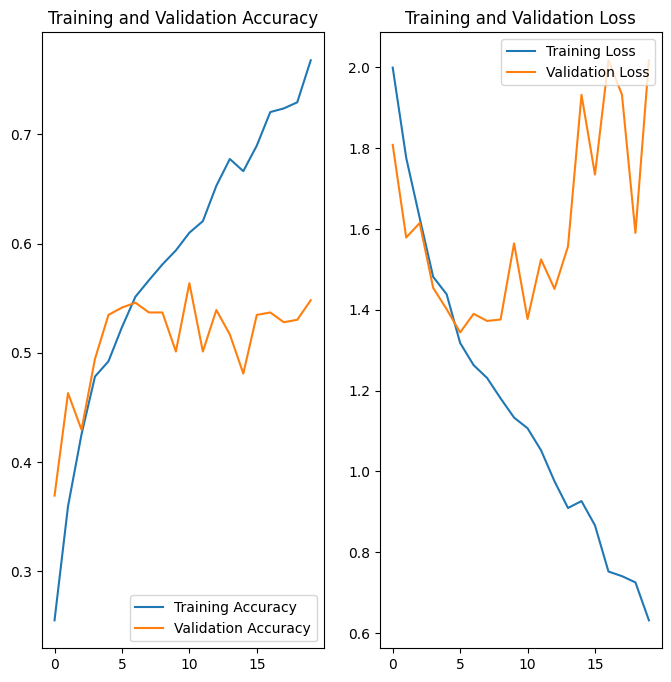

In [92]:
#Plot
plot_model(history2,INITIAL_NUMBER_OF_EPOCHS)

##### **Observations:**

- Training Accuracy (`~76.8%`), Validation Accuracy (`54.8%`). Though training accuracy is reduced, the gap between train and validation accuracy is relatively reduced.
- Training Loss (`0.63`), Validation Loss (`2.01`). Training loss is increased relatively as compared to initial model, the gap between training and validation loss is reduced.
- **`Still the model is over fitting.`**

##### **Model3**: With Dropouts, BN
- This model inclued BN, to have regularization, and reduce overfitting.

In [18]:
# 3rd Model Adding Dropouts, Batch Normalization
#Model with any dropout and without batch normalization
model3 = get_model(True,True)

In [94]:
#Summary
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 87, 87, 64)      

In [19]:
#Model Compilation
model3.compile(optimizer=MODEL_OPTIMIZER,loss=MODEL_LOSS,metrics=[MODEL_METRICS])

In [20]:
# Train the model
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=INITIAL_NUMBER_OF_EPOCHS)

Epoch 1/20
56/56 [==============================] - 248s 4s/step - loss: 1.8354 - accuracy: 0.4213 - val_loss: 2.8011 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 228s 4s/step - loss: 1.4341 - accuracy: 0.4978 - val_loss: 2.9201 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 233s 4s/step - loss: 1.2549 - accuracy: 0.5564 - val_loss: 3.0576 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 226s 4s/step - loss: 1.1151 - accuracy: 0.6122 - val_loss: 3.2074 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 227s 4s/step - loss: 1.0019 - accuracy: 0.6523 - val_loss: 3.2825 - val_accuracy: 0.1521
Epoch 6/20
56/56 [==============================] - 228s 4s/step - loss: 0.8903 - accuracy: 0.6892 - val_loss: 2.6473 - val_accuracy: 0.2170
Epoch 7/20
56/56 [==============================] - 221s 4s/step - loss: 0.7403 - accuracy: 0.7416 - val_loss: 2.6550 - val_accuracy: 0.2819
Epoch 8/20
56

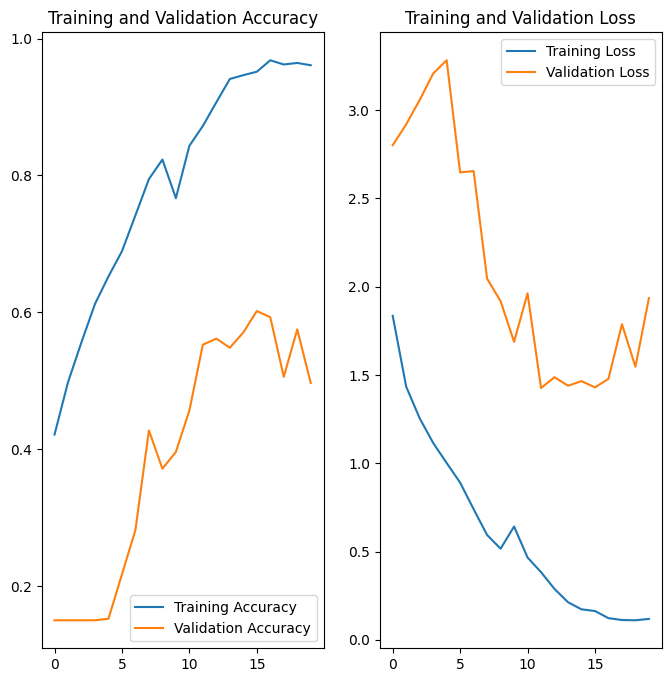

In [21]:
#Plot
plot_model(history3,INITIAL_NUMBER_OF_EPOCHS)

##### **Observations**:

- Training Accuracy (`96%`), Validation Accuracy (`49.6%`). The difference shows model is clearly ovverfitting.
- Training Loss (`0.1187`), Validation Loss (`1.934`).
- So  **`batch normalization is not helping,  it is leading to overfitting`**.  The observation is worse than model2 (Dropouts without BN).

#### 3.2 **Model4**: Model Building with Augmented Data

In [27]:
#Get Augmented Model, where augmentation done at preprocessing step
model4 = get_augmented_model()

In [28]:
#Model Summary
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [29]:
#Model Compilation
model4.compile(optimizer=MODEL_OPTIMIZER,loss=MODEL_LOSS,metrics=[MODEL_METRICS])

In [30]:
#Fit the Model
history4 = model4.fit(train_ds, validation_data=val_ds, epochs=INITIAL_NUMBER_OF_EPOCHS)

Epoch 1/20
56/56 [==============================] - 168s 3s/step - loss: 2.1368 - accuracy: 0.2299 - val_loss: 1.9621 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 163s 3s/step - loss: 1.8995 - accuracy: 0.3131 - val_loss: 1.8105 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 159s 3s/step - loss: 1.7688 - accuracy: 0.3705 - val_loss: 1.6958 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 164s 3s/step - loss: 1.6340 - accuracy: 0.4291 - val_loss: 1.7124 - val_accuracy: 0.3826
Epoch 5/20
56/56 [==============================] - 163s 3s/step - loss: 1.5604 - accuracy: 0.4498 - val_loss: 1.5255 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 164s 3s/step - loss: 1.4419 - accuracy: 0.4911 - val_loss: 1.3825 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 171s 3s/step - loss: 1.3752 - accuracy: 0.5100 - val_loss: 1.3853 - val_accuracy: 0.5034
Epoch 8/20
56

##### **Observations**:
- With Augmentation the model the training accuracy (`58.1%`) is also reduced. Though the difference between training and validation accuracy (`52.8%`) is reduced, it looks the model is `underfitting`.
- Moreover, even the loss also increased in this case for training (`1.18`), as well as validation(`1.30`)

#### 3.3 Handling class imbalances

Check the class Distribution Count

In [31]:
# Get directory names, and file count in each directory.
dir_names,file_count = get_class_distribution_count(train_data_dir)
class_dist_df = pd.DataFrame(list(zip(dir_names,file_count)),columns =['ClassName', 'Image Count'])
class_dist_df

,ClassName,Image Count
0,nevus,357
1,pigmented benign keratosis,462
2,squamous cell carcinoma,181
3,basal cell carcinoma,376
4,melanoma,438
5,seborrheic keratosis,77
6,dermatofibroma,95
7,actinic keratosis,114
8,vascular lesion,139


<Axes: xlabel='Image Count', ylabel='ClassName'>

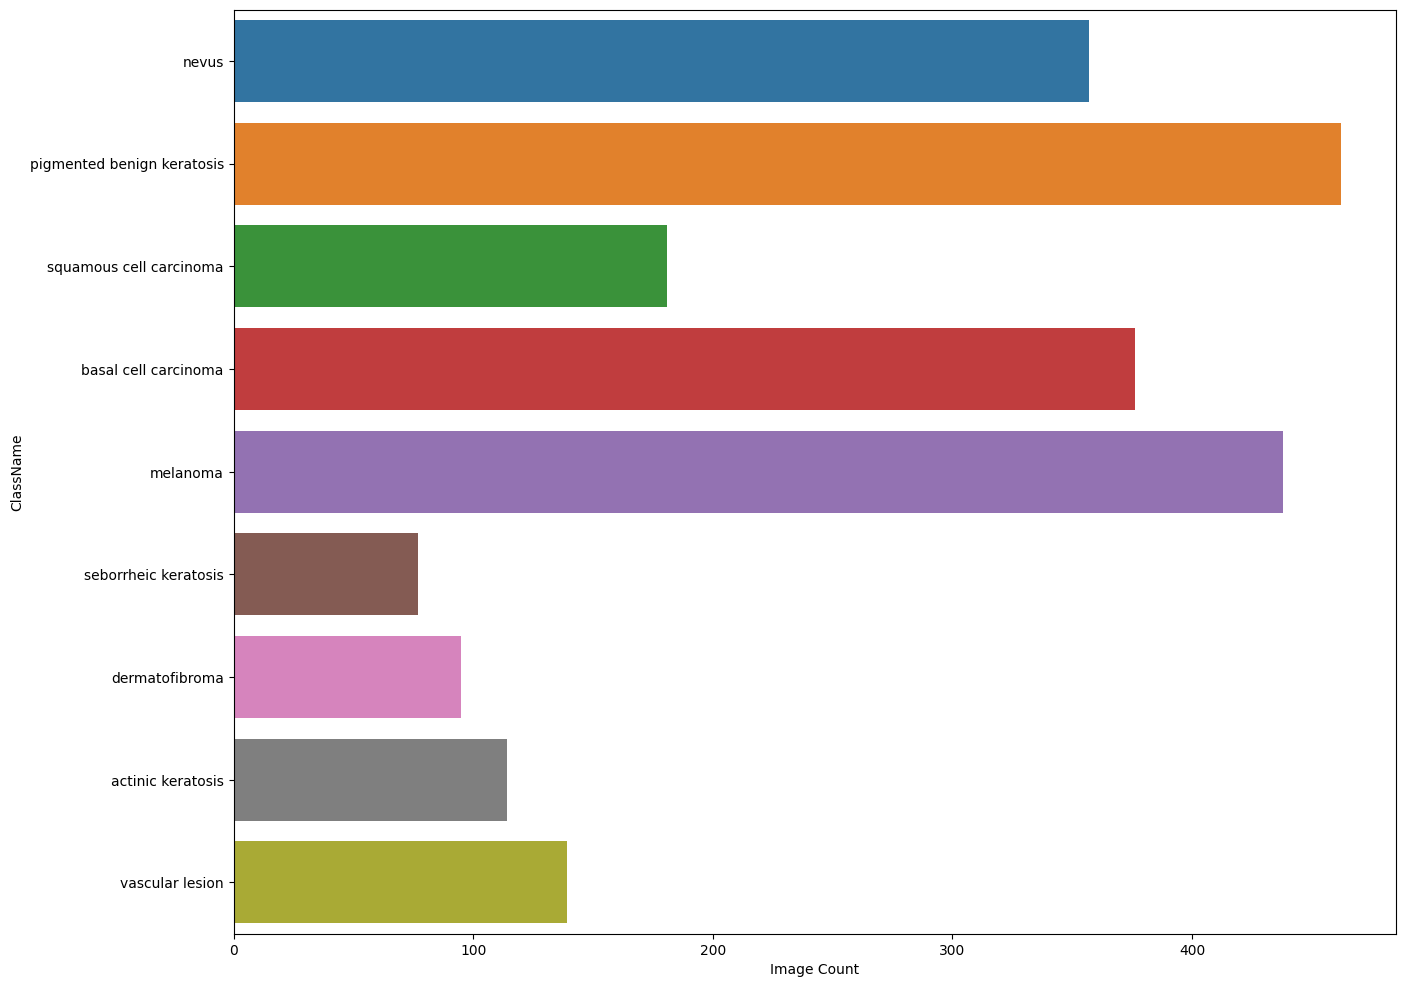

In [51]:
#Visualization of the class distribution
import seaborn as sns
plt.figure(figsize=(15, 12))
sns.barplot(x="Image Count", y="ClassName", data=class_dist_df)

- What is **Imbalance**?
  - A classification data set with skewed class proportions is called imbalanced
- As per the above count, it clearly indicates there is **class imbalance**, as the data is skewed, and there are more images of the class `pigmented benign keratosis` and `Melanoma` (>400), and relatively fewer images of `seborrheic keratosis ` and `dermatofibroma` (<100)

#####  **Augmentor Library:**
- Augmentor library is used to add additional images, to address class imbalance problem

In [32]:
#Install Augmentor Library
!pip install Augmentor

In [76]:
#To remove output directory, is alreay present
# This is to ensure the directory is removed on multiple rerun
output_dir_prefix  = "/content/Train/"
for i in class_names:
  output_dir = output_dir_prefix+i+"/output/"
  try:
      shutil.rmtree(output_dir)
      print("Removed",output_dir)
  except OSError as e:
      print("Error: %s - %s." % (e.filename, e.strerror))

Removed /content/Train/actinic keratosis/output/
Removed /content/Train/basal cell carcinoma/output/
Removed /content/Train/dermatofibroma/output/
Removed /content/Train/melanoma/output/
Removed /content/Train/nevus/output/
Removed /content/Train/pigmented benign keratosis/output/
Removed /content/Train/seborrheic keratosis/output/
Removed /content/Train/squamous cell carcinoma/output/
Removed /content/Train/vascular lesion/output/


In [77]:
#Original Path list
path_list_orig = [x for x in glob.glob(os.path.join(train_data_dir, '*', '*.jpg'))]
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_data_dir, '*', '*.jpg'))]

In [78]:
original_dict = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Train/nevus/ISIC_0000047.jpg,Train
1,/content/Train/nevus/ISIC_0000425.jpg,Train
2,/content/Train/nevus/ISIC_0000536.jpg,Train
3,/content/Train/nevus/ISIC_0000439.jpg,Train
4,/content/Train/nevus/ISIC_0000387.jpg,Train
...,...,...
2234,/content/Train/vascular lesion/ISIC_0028431.jpg,Train
2235,/content/Train/vascular lesion/ISIC_0027790.jpg,Train
2236,/content/Train/vascular lesion/ISIC_0031901.jpg,Train
2237,/content/Train/vascular lesion/ISIC_0030606.jpg,Train


In [79]:
## Procedure to use Pipeline
#Instantiate a Pipeline object pointing to a directory containing your initial image data set.
#Define a number of operations to perform on this data set using your Pipeline object.
#Execute these operations by calling the Pipeline’s sample() method.
path_to_training_dataset = "/content/Train/"
import Augmentor
for i in class_names:
  print(path_to_training_dataset+i)
  p = Augmentor.Pipeline(path_to_training_dataset+i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)

/content/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F055714A770>: 100%|██████████| 500/500 [00:23<00:00, 20.86 Samples/s]


/content/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0551F1E260>: 100%|██████████| 500/500 [00:23<00:00, 21.33 Samples/s]


/content/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F056B6FBAC0>: 100%|██████████| 500/500 [00:26<00:00, 18.93 Samples/s]


/content/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0556F93E50>: 100%|██████████| 500/500 [02:07<00:00,  3.92 Samples/s]


/content/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0551C41600>: 100%|██████████| 500/500 [01:55<00:00,  4.33 Samples/s]


/content/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0568400BE0>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


/content/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05681C1CF0>: 100%|██████████| 500/500 [00:56<00:00,  8.84 Samples/s]


/content/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05567EF400>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]


/content/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0553282800>: 100%|██████████| 500/500 [00:25<00:00, 19.51 Samples/s]


In [80]:
#Check the total number of images after Augmentation
# As the Augmentor generates in the "output" sub folder,
# So path is given with /output/
image_count_train = len(list(train_data_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


- For each class 500 images gets added. So total images added are 4500.

**Check the distribution of augmented data after adding new images to the original training data.**

In [81]:
path_list = [x for x in glob.glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]

In [82]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_data_dir, '*','output', '*.jpg'))]

In [83]:
#Create a Data Frame of Path, Labels for newly added images
dataframe_dict_new = dict(zip(path_list, lesion_list))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/Train/nevus/output/nevus_original_ISI...,nevus
1,/content/Train/nevus/output/nevus_original_ISI...,nevus
2,/content/Train/nevus/output/nevus_original_ISI...,nevus
3,/content/Train/nevus/output/nevus_original_ISI...,nevus
4,/content/Train/nevus/output/nevus_original_ISI...,nevus
...,...,...
4495,/content/Train/vascular lesion/output/vascular...,vascular lesion
4496,/content/Train/vascular lesion/output/vascular...,vascular lesion
4497,/content/Train/vascular lesion/output/vascular...,vascular lesion
4498,/content/Train/vascular lesion/output/vascular...,vascular lesion


In [87]:
#Append Original df
new_df = pd.concat([original_df, df2], axis=0)
new_df

,Path,Label
0,/content/Train/nevus/ISIC_0000047.jpg,Train
1,/content/Train/nevus/ISIC_0000425.jpg,Train
2,/content/Train/nevus/ISIC_0000536.jpg,Train
3,/content/Train/nevus/ISIC_0000439.jpg,Train
4,/content/Train/nevus/ISIC_0000387.jpg,Train
...,...,...
4495,/content/Train/vascular lesion/output/vascular...,vascular lesion
4496,/content/Train/vascular lesion/output/vascular...,vascular lesion
4497,/content/Train/vascular lesion/output/vascular...,vascular lesion
4498,/content/Train/vascular lesion/output/vascular...,vascular lesion


- Total images 6739, after using augmentor library.

##### **Model5**: Model Building after addressing class imbalance

In [42]:
#Splitting Train DataSet
#subset is  set as "training" to get only train data set
#load  images off disk using the  image_dataset_from_directory utility
#"seed" is used as 123 as recommended
train_ds_aug = preprocessing.image_dataset_from_directory(train_data_dir,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=(180,180),
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset="training")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [40]:
val_ds_aug = preprocessing.image_dataset_from_directory(train_data_dir,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=(180,180),
                                                               seed=123,
                                                               validation_split=0.2,
                                                               subset="validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [43]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
#Model with dropouts and without BN
model5 = get_model(True,False)

In [45]:
#Model Summary
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

In [46]:
#Model Compilation
model5.compile(optimizer=MODEL_OPTIMIZER,loss=MODEL_LOSS,metrics=[MODEL_METRICS])

In [47]:
#Model Fit
history5 = model5.fit(train_ds_aug, validation_data=val_ds_aug, epochs=FINAL_NUMBER_OF_EPOCHS)

Epoch 1/30
169/169 [==============================] - 503s 3s/step - loss: 1.8216 - accuracy: 0.3045 - val_loss: 1.5005 - val_accuracy: 0.4588
Epoch 2/30
169/169 [==============================] - 474s 3s/step - loss: 1.4892 - accuracy: 0.4399 - val_loss: 1.2553 - val_accuracy: 0.5449
Epoch 3/30
169/169 [==============================] - 475s 3s/step - loss: 1.3623 - accuracy: 0.4905 - val_loss: 1.3496 - val_accuracy: 0.4907
Epoch 4/30
169/169 [==============================] - 472s 3s/step - loss: 1.2280 - accuracy: 0.5373 - val_loss: 1.0999 - val_accuracy: 0.5835
Epoch 5/30
169/169 [==============================] - 470s 3s/step - loss: 1.1041 - accuracy: 0.5805 - val_loss: 1.1175 - val_accuracy: 0.5895
Epoch 6/30
169/169 [==============================] - 464s 3s/step - loss: 1.0055 - accuracy: 0.6152 - val_loss: 0.9053 - val_accuracy: 0.6726
Epoch 7/30
169/169 [==============================] - 478s 3s/step - loss: 0.8804 - accuracy: 0.6728 - val_loss: 0.8137 - val_accuracy: 0.7120

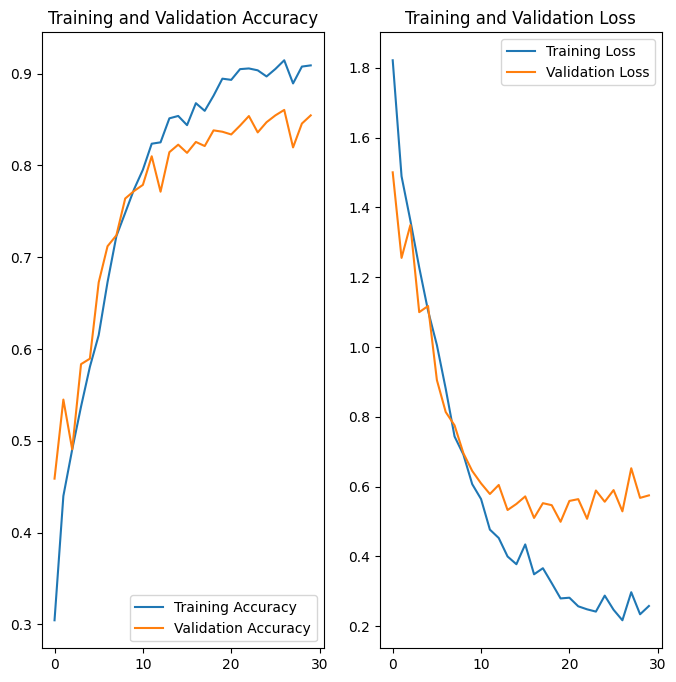

In [48]:
#Plot the model
plot_model(history5,FINAL_NUMBER_OF_EPOCHS)

Observations:
- Train accuracy (`90.8%`), validation accuracy (`85.4%`) after 30 loops.
- With Augmentor library, Train and validation accuracy are close, **so the overfitting problem is also addressed**.
- Even the Loss for training (`0.2580`), and test (`0.5749`) are also almost closer.

### 4. Model Prediction

- Model prediciton is done for sample images of each class to confirm, whether all classes of cancer are detected properly or not.

In [58]:
#Take 1 sample of each class and check, if model predicts properly.
for each_class in class_names:
  curr_path = str(train_data_dir)+'/'+each_class+'/'
  #Take the 1st file
  class_file_path[each_class] = curr_path + os.listdir(curr_path)[0]
  # Resize the image to intended size.
  test_image = load_img(class_file_path[each_class],target_size=(180,180,3))
  #Expand dimensions to show axis
  img = np.expand_dims(test_image,axis=0)
  pred = model5.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class: "+ each_class)
  print("Predictive Class: "+ pred_class)

1/1 [==============================] - 0s 170ms/step
Actual Class: actinic keratosis
Predictive Class: actinic keratosis
1/1 [==============================] - 0s 51ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma
1/1 [==============================] - 0s 44ms/step
Actual Class: dermatofibroma
Predictive Class: dermatofibroma
1/1 [==============================] - 0s 49ms/step
Actual Class: melanoma
Predictive Class: melanoma
1/1 [==============================] - 0s 44ms/step
Actual Class: nevus
Predictive Class: nevus
1/1 [==============================] - 0s 46ms/step
Actual Class: pigmented benign keratosis
Predictive Class: pigmented benign keratosis
1/1 [==============================] - 0s 49ms/step
Actual Class: seborrheic keratosis
Predictive Class: seborrheic keratosis
1/1 [==============================] - 0s 45ms/step
Actual Class: squamous cell carcinoma
Predictive Class: squamous cell carcinoma
1/1 [==============================] - 0s 47m

- So the model is working well on sample images of test data.